In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
import os

# allows for priting big dataframes
pd.options.display.max_rows = None 
pd.options.display.max_columns = None

# flag that changes how plots are generated, so they can be visualized at GitHub
github_page = True


# NA's dataframe Creator
This function creates 2 dataframes: the first contains the total number of na values by each country and feature, and the second contains the na proportion for that country and feature


In [2]:
def na_dfs(data):
    '''
    Returns total number of nas per feature and feature percentage of nas, for each country
    '''

    # saves nas count, as well as percentage of nas for each feature, correpoding to each country
    total_nas_df = data.isna().groupby('location').sum() # total number of nas per feature
    nas_perc = total_nas_df.div(data.groupby('location').size(), axis='rows')  * 100   # feature percentage     of nas, for each country

    return total_nas_df, nas_perc


# Initial Processing
Loads dataframe;

Set "location" and "date" as indexes (making it a multindex dataframe);

Drops unwanted countries (criteria explined bellow);

Drops unwanted features (criteria explined bellow);

Sets gpd per capita for Cuba.

In [3]:
# load dataframes
data = pd.read_csv('owid_covid_data_June-14-2020.csv')

# converts date from string to pandas datetimeindex format
data.date = pd.DatetimeIndex(data.date)

# transforms dataframe into a multindex (location and date) dataframe
index = pd.MultiIndex.from_frame(data[['location', 'date']])
data.set_index(index, inplace=True)
data.sort_index(inplace=True)
data.drop(columns=['location', 'date'], inplace=True)

# update na's dataframes
total_nas_df, nas_perc = na_dfs(data)

# drops unwanted countries
countries_to_drop = ['International','Hong Kong'] # removed for lack of data
countries_to_drop.extend(['Curacao', 'French Polynesia', 'Guam', 'New Caledonia', 'Somalia', 'United States Virgin Islands']) # removed for lack of gdp per capita data
countries_to_drop.extend(nas_perc[nas_perc['population_density'] != 0].index.values) # countries with missing values for population density are eliminated
countries_to_drop.extend(nas_perc[(nas_perc['median_age'] != 0) | (nas_perc['aged_65_older'] != 0)].index.values) # countries with missing values for median age or aged 65 older are eliminated
countries_to_drop.extend(['Aruba']) # removed for lack of cvd death rate data
countries_to_drop.extend(nas_perc[nas_perc['stringency_index'] == 100].index.values) # removed countries that have no recorded stringency index (those with only some missing values will be completed with already available data)
data.drop(countries_to_drop, inplace=True)

# drops unwanted features
columns_to_drop = ['total_tests', 'new_tests', 'new_tests_smoothed', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'tests_units'] # tests columns removed for lack of data
columns_to_drop.extend(['continent'])   # not necessary
columns_to_drop.extend(['aged_70_older']) # removed for duplicity of data (there is already a aged 65 older column)
data.drop(columns=columns_to_drop, inplace=True)

data.loc['Cuba']['gdp_per_capita'] = 20611.0 # data obtained from https://pt.wikipedia.org/wiki/Lista_de_pa%C3%ADses_por_PIB_(Paridade_do_Poder_de_Compra)_per_capita (it was very hard to find data from Cuba that was recent. The most recent data was an estimate by the CIA, but we can safely assume that this data would be biased)


/home/claudio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Filling missing dates
Some countries have missing date entries; these will be added by filling the gaps, so their respective features can filled later.

In [4]:
# fill in missing dates, using the range between the earliest and latest recorded samples
start_date = data.index.get_level_values('date').min()
end_date = data.index.get_level_values('date').max()
date_range = pd.date_range(start_date, end_date)
date_range = pd.Index(date_range, name='date')
countries = data.groupby('location').max().index
new_index = pd.MultiIndex.from_product([countries, date_range])
data = data.reindex(new_index)

columns_to_prop = ['iso_code',    # data is constant for each country, so first fill Na's with forward pad for Na's that are on tail, then with backward pad for Na's that are on start of each country
                    'population',
                    'population_density',
                    'median_age',      
                    'aged_65_older',
                    'gdp_per_capita',
                    'cvd_death_rate',
                    'diabetes_prevalence']
data[columns_to_prop] = data[columns_to_prop].groupby('location').fillna(method='backfill') # backward propagation
data[columns_to_prop] = data[columns_to_prop].groupby('location').fillna(method='ffill')    # forward propagation

# Adquiring John Hopkins University data
Loads and process data from JHU, in order to obtain the number of currently infected people.

In [ ]:
jhu_data = pd.read_csv('JHU_COVID-19 (1).csv')
jhu_data

/home/claudio/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
# removes duplicate and unwanted columns
jhu_data['Country_Region'].fillna(jhu_data['Country/Region'], inplace=True)
jhu_data['Province_State'].fillna(jhu_data['Province/State'], inplace=True)

jhu_data.drop(columns=['Unnamed: 0', 'Combined_Key', 'Last_Update', 'Country/Region', 'Province/State', 'Last Update', 'Lat', 'Latitude', 'Longitude', 'Long_'], inplace=True)

jhu_data.Country_Region.replace(to_replace='US', value='United States', inplace=True)   # replaces US with United States
jhu_data.Country_Region.replace(to_replace='UK', value='United Kingdom', inplace=True)
jhu_data.Country_Region.replace(to_replace='Taiwan*', value='Taiwan', inplace=True)
jhu_data.Country_Region.replace(to_replace='Russian Federation', value='Russia', inplace=True)
jhu_data.Country_Region.replace(to_replace=' Azerbaijan', value='Azerbaijan', inplace=True)
jhu_data.Country_Region.replace(to_replace='Korea, South', value='South Korea', inplace=True)
jhu_data.Country_Region.replace(to_replace='Viet Nam', value='Vietnam', inplace=True)
jhu_data.Country_Region.replace(to_replace='Republic of Korea', value='South Korea', inplace=True)
jhu_data.Country_Region.replace(to_replace='Republic of Ireland', value='Ireland', inplace=True)
jhu_data.Country_Region.replace(to_replace='Republic of Moldova', value='Moldova', inplace=True)
jhu_data.Country_Region.replace(to_replace='Mainland China', value='China', inplace=True)
jhu_data.Country_Region.replace(to_replace='Iran (Islamic Republic of)', value='Iran', inplace=True)
jhu_data.Country_Region.replace(to_replace='Hong Kong SAR', value='Hong Kong', inplace=True)
jhu_data.Country_Region.replace(to_replace='Gambia, The', value='Gambia', inplace=True)
jhu_data.Country_Region.replace(to_replace='Bahamas, The', value='Bahamas', inplace=True)
jhu_data.Country_Region.replace(to_replace='Eswatini', value='Swaziland', inplace=True)
jhu_data.Country_Region.replace(to_replace=['Timor-Leste', 'East-Timor'], value='Timor', inplace=True)


jhu_data.Country_Region.replace(to_replace='Republic of the Congo', value='Congo', inplace=True)
jhu_data.loc[jhu_data['Country_Region'] == 'Congo'] = jhu_data.loc[jhu_data['Country_Region'] == 'Congo'].combine_first(jhu_data.loc[jhu_data['Country_Region'] == 'Congo (Kinshasa)'])
jhu_data.loc[jhu_data['Country_Region'] == 'Congo'] = jhu_data.loc[jhu_data['Country_Region'] == 'Congo'].combine_first(jhu_data.loc[jhu_data['Country_Region'] == 'Congo (Brazzaville)'])

jhu_data.rename(columns={'Country_Region': 'location'}, inplace=True)   # renames location column
jhu_data.columns = map(str.lower, jhu_data.columns) # lower all column names

# converts the date column to dataframe
jhu_data.date = pd.DatetimeIndex(jhu_data.date)

# transforms dataframe into a multindex (location and date) dataframe
index = pd.MultiIndex.from_frame(jhu_data[['location', 'date']])
jhu_data.set_index(index, inplace=True)
jhu_data.sort_index(inplace=True)
jhu_data.drop(columns=['location', 'date'], inplace=True)

# reorder columns
jhu_data = jhu_data[['confirmed', 'deaths', 'recovered', 'active', 'incidence_rate', 'case-fatality_ratio']]

# groups all entries that are of same country and date but are divided in provinces or states
jhu_data = jhu_data.groupby(['location', 'date']).sum()

# joins JHU data column "recovered" with dataframe
data = data.join(other=jhu_data[['confirmed', 'deaths', 'recovered']], how='left')
data.rename(columns={'confirmed': 'total_cases_jhu', 'deaths': 'total_deaths_jhu', 'recovered': 'total_recovered_jhu'}, inplace=True) # replaces name for 'recovered' and 'confirmed' features, so they can better match naming of other features

# Replacement of data from *OWID* to *JHU*
Due to lack of number recovered people from *OWID* data, John Hopkins University's reports will be the new source of data. However, since *JHU* data starts only on 22/01/2020, early days of *OWID* will be used to fill that gap.

In [42]:

index_early_days = data.index.get_level_values('date') < pd.Timestamp('2020/01/22') # index of early days

# cases
data['total_cases_jhu'][index_early_days] = data['total_cases'][index_early_days]
data['total_cases'] = data['total_cases_jhu']
data.drop(columns='total_cases_jhu', inplace=True)

# deaths
data['total_deaths_jhu'][index_early_days] = data['total_deaths'][index_early_days]
data['total_deaths'] = data['total_deaths_jhu']
data.drop(columns='total_deaths_jhu', inplace=True)

# recovered
data['total_recovered'] = data['total_recovered_jhu']
data.drop(columns='total_recovered_jhu', inplace=True)



# Amount of null values after merging
After merging the data between sources, we need to check for new Nan values introduced in the data.

In [43]:
# shows amount of Nan values on new columns after
columns = ['total_cases', 'total_deaths', 'total_recovered']
data[columns].isna().groupby('location').sum()

,total_cases,total_deaths,total_recovered
location,,,
Afghanistan,33.0,33.0,55.0
Albania,69.0,69.0,69.0
Algeria,34.0,34.0,56.0
Angola,80.0,80.0,80.0
Argentina,63.0,63.0,63.0
Australia,2.0,2.0,24.0
Austria,34.0,34.0,56.0
Azerbaijan,38.0,38.0,60.0
Bahrain,33.0,33.0,55.0


In [44]:
# removes countries that have too many Nan values
countries_to_drop = ['Cape Verde', 'Congo', 'Democratic Republic of Congo', 'Czech Republic', 'Myanmar', 'Palestine', 'Puerto Rico']
data.drop(countries_to_drop, inplace=True)


# Tracking Amount of Days Into the Pandemic for Each Country
Creates a new column: "days_into_pandemic". It holds each entry's days passed since the first day with recorded cases.

Also replaces all Na values in days after the pandemic started with interpolations, and days before that with zeroes.



In [45]:
# creation of 'days_into_pandemic' column, that contains the number of days since the pandemic started in each country
first_day = data.groupby('location')['total_cases'].apply(lambda total_cases: total_cases[total_cases > 0].index[0][1])  # series containing first day of pandemic for each country

def calc_days_into_pandemic(row):
    # receives each row from dataframe as a series and computes the number of days into pandemic using the 'first_day' series created above
    
    # name of series is the index corresponding row from dataframe
    country = row.name[0]
    date = row.name[1]
    return date - first_day.loc[country]


data['days_into_pandemic'] = data.apply(calc_days_into_pandemic , axis=1)
data['days_into_pandemic'] = data['days_into_pandemic'].apply(lambda timedelta: timedelta.days) # converts feature from pandas Timedelta format to integer

# replacement of all the na values that occur AFTER the first day of pandemic (those that happend before will be replaced by zeroes, since the pandemic hasn't started yet)
change_columns = ['total_cases', 'total_deaths', 'total_recovered']
interpolations = data.groupby('location').transform(lambda country: country.interpolate()) # interpolation for missing values of update columns
# only na values that happend AFTER the first day of pandemic will be replaced by interpolations
data[change_columns] = data[change_columns].where(cond = (data['days_into_pandemic'] <= 0) & (data['total_cases'].isnull()), other = interpolations)

# fill other Na spots with 0's
data[change_columns] = data[change_columns].fillna(0)


# Checking for negative changing in cumulative data
All cumulative features (*total_cases*, *total_deaths* and *total_recovered*) must always increment with time; negative values in temporal change will then be tested for each one.

In [46]:
columns = ['total_cases', 'total_deaths', 'total_recovered']
diffs = data[columns].groupby('location').diff()
count_negatives = diffs[diffs < 0].groupby('location').count().sum()
print("Negative values:\n")
print(count_negatives)


Negative values:

total_cases        38
total_deaths       24
total_recovered    57
dtype: int64


# Cleaning negative changes in cumulative data
As can be seen above, there are several negative temporal changes on cumulative features in the data. One interpretation could be that due to difficulty on reporting the pandemic some readings may be overestimated and then later on the reporting institutions and governments would correct it by bringing the cumulative count down. To correct this all cumulative values that are judged to be overestimated based on this criteria will be replaced by interpolations.

In [47]:
def interpolation_adjustment(country):
    '''
    Adjusts incoherent values with interpolation
    '''
    diffs = country.diff()
    negative_indexes = diffs[diffs < 0].index # indexes that have negative differences
    for index in negative_indexes:
        country.loc[:index][country > country.loc[index]] = np.nan

    return country.interpolate(limit_direction='both')

columns = ['total_cases', 'total_deaths', 'total_recovered']

for column in columns:
    data[column]= data[column].groupby('location').transform(func=interpolation_adjustment)


# Creating *total_active* feature

The original *total_active* feature was present on the John Hopkins University data; however, since it was only a calculation based on the *total_cases*, *total_deaths* and *total_recovered* features, it was decided to create it after some data cleaning on the generating features.


In [48]:
data['total_active'] = data['total_cases'] - data['total_deaths'] - data['total_recovered']

# Creating "*susceptibles*" column
The *susceptible* feature is created by subtracting *total_active*, *total_recovered* and *total_deaths* from the total population.

In [49]:
data['total_susceptibles'] = data['population'] - (data['total_active'] + data['total_recovered'] + data['total_deaths'])   # creates new feature

# Defining change and density features
Now that the data has been cleaned, some specific features can be created. Change (temporal changes in features, or first-order difference) and density (amount of people in that condition per million habitants) features will be created.

In [50]:
columns = ['cases', 'deaths', 'recovered', 'active', 'susceptibles']
for column in columns:
    data['new_{}'.format(column)] = data['total_{}'.format(column)].groupby('location').diff()  # new
    data['total_{}_per_million'.format(column)] = data['total_{}'.format(column)] / (data['population'] / 1e6)   # total per million
    data['new_{}_per_million'.format(column)] = data['new_{}'.format(column)] / (data['population'] / 1e6) # new per million

# Stringency Index Filling
Replace missing values in the "stringency_index" column using forward propagation (we're assuming that the stringency index will remain the same until it changes in some next entry)

In [51]:
# replace nas in stringency index column using forward propagation (previous valid observations are used to fill nas)
data['stringency_index'] = data['stringency_index'].groupby('location').fillna(method='ffill')

# replace remaining nas in stringency_index column (those that don't have have any previous valid value) with zeroes
data['stringency_index'] = data['stringency_index'].groupby('location').fillna(0)
# updates na's dataframes
total_nas_df, nas_perc = na_dfs(data)


# Visualization of *new_cases_per_million*

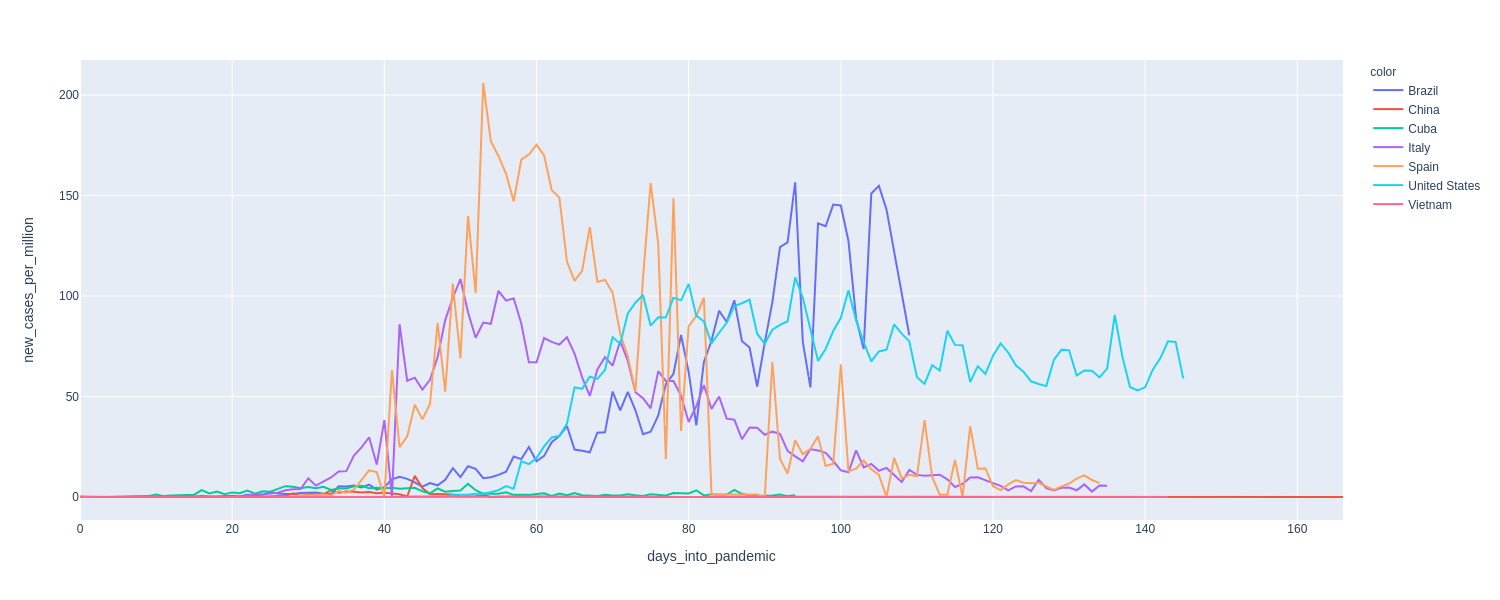

In [52]:
countries = ['Brazil', 'United States', 'Italy', 'Spain', 'China', 'Vietnam', 'Cuba']
to_plot = data[data['days_into_pandemic'] >= 0].loc[countries]

fig = px.line(to_plot, x='days_into_pandemic', y='new_cases_per_million', color=to_plot.index.get_level_values('location'), height=600, width=1500)

if github_page:
    fig.show('png', height=600, width=1500)
else:
    fig.show()


# Smoothing *new_cases_per_million*
The "*new_cases_per_million*" feature is highly noisy. A new column "*new_cases_per_million_smoothed"* will be created by averaging the values from the last 5 days for each country.

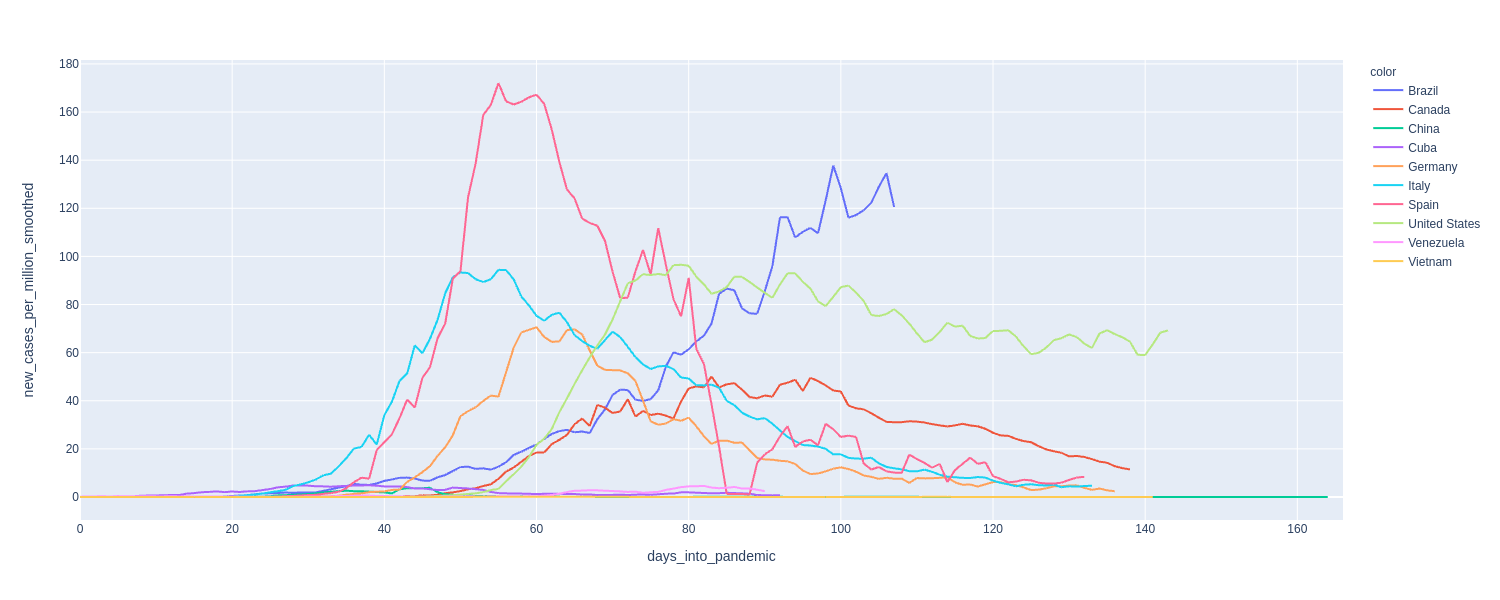

In [53]:
data['new_cases_per_million_smoothed'] = data['new_cases_per_million'].groupby('location').rolling(5, center=True).mean().droplevel(0)    # for some reason, rolling combined in a group by results in duplication of index; thus, it must be removed with droplevel

countries = ['Brazil', 'United States', 'Italy', 'Spain', 'China', 'Vietnam', 'Cuba', 'Venezuela', 'Germany', 'Canada']
to_plot = data[data['days_into_pandemic'] >= 0].loc[countries]
fig = px.line(to_plot, x='days_into_pandemic', y='new_cases_per_million_smoothed', color=to_plot.index.get_level_values('location'), height=600, width=1500)

if github_page:
    fig.show('png', height=600, width=1500)
else:
    fig.show()

# Creating "*infection_rate*" feature
The *infection_rate* is calculated by using a simplification of the formula $\displaystyle \frac{dI}{dt} =  \beta I S - \gamma I$, used by the [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) to describe infection behavior:

- $\beta$ =  *Infection rate*
- $I$ = *People **currently** infected*
- $S$ = *People susceptible to infection*
- $\gamma$ = *Recovery rate*

Since we are interested on the total number of cases (not only people who are currently infected, but the historical amount of infections), $\displaystyle \frac{dI}{dt}$ can be replaced with $\displaystyle \frac{dC}{dt}$ and $ - \gamma I $ can be removed ($ - \gamma I $ accounts for the change in recovered people). We end up with $\displaystyle \frac{dC}{dt} =  \beta I S$, where:

- $\displaystyle \frac{dC}{dt}$ = *new_cases_per_million_smoothed*, on day $t$.
- $\beta$ = *infection_rate*, the new feature which we're trying to compute, on day $t-1$.
- $I$ = *total_active_per_million* on the day before, $t - 1$.
- $S$ = *susceptibles_per_million* on the day before, $t - 1$.

The new *infection_rate* feature, on a day $t$, will then be:
$\displaystyle infection\_rate_{t} = \frac{new\_cases\_per\_million\_smoothed_{t + 1}}{susceptibles\_per\_million_{t} \times total\_active\_per\_million_{t}} $

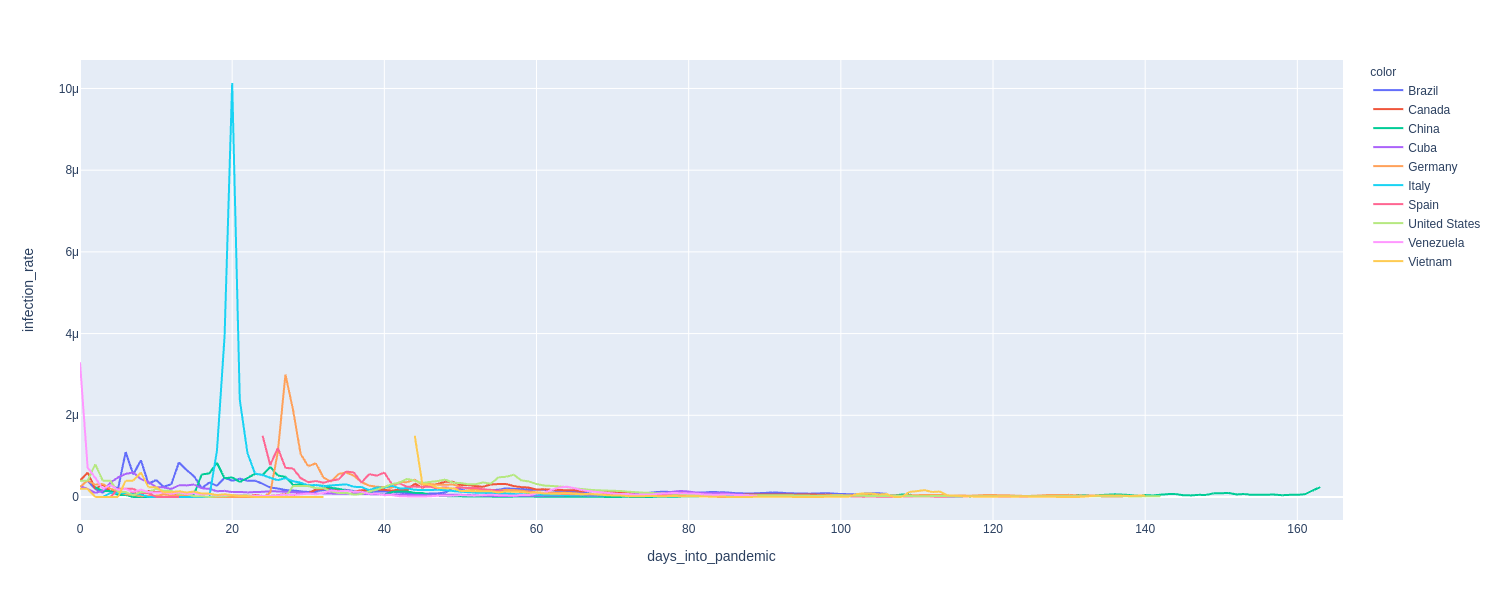

In [54]:
data['infection_rate'] = data['new_cases_per_million_smoothed'].groupby('location').shift(-1) / (data['total_susceptibles_per_million'] * data['total_active_per_million'])
data['infection_rate'].where(data['total_active_per_million'] > 0, other=np.nan, inplace=True)   # invalidation of values generated when there were no active people

countries = ['Brazil', 'United States', 'Italy', 'Spain', 'China', 'Vietnam', 'Cuba', 'Venezuela', 'Germany', 'Canada']
to_plot = data[data['days_into_pandemic'] >= 0].loc[countries]

fig = px.line(to_plot, x='days_into_pandemic', y='infection_rate', color=to_plot.index.get_level_values('location'), height=600, width=1500)

if github_page:
    fig.show('png', height=600, width=1500)
else:
    fig.show()




# Finding the cross correlation between *infection_rate* and past *stringency_index* values
The *infection_rate* feature is possibly linked to the *stringency_index* by a lag of some days (since infected people take some time to develop symptoms, stringency measures will likely have a correlation with how fast new people get infected in the future). A simple cross correlation will be applied between *infection_rate* and past values of *stringency_index*, using the Pearson correlation coefficient.

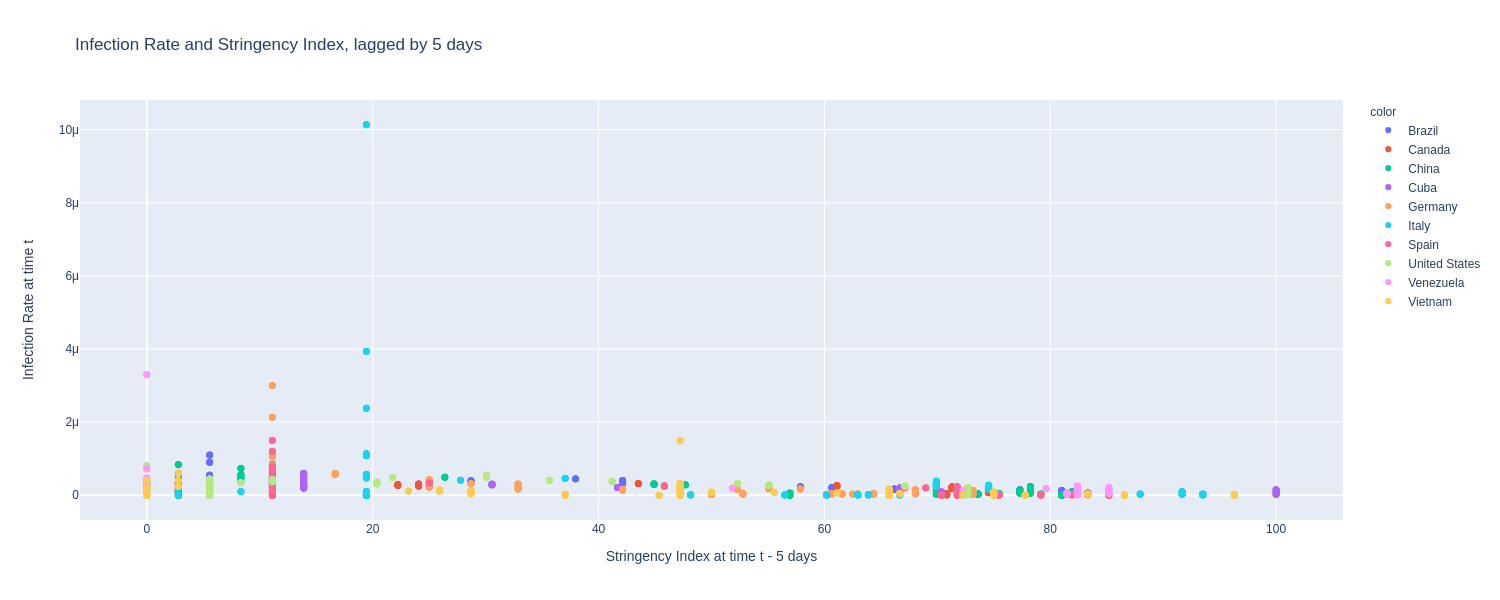

In [55]:
lag_days = 5
countries = ['Brazil', 'United States', 'Italy', 'Spain', 'China', 'Vietnam', 'Cuba', 'Venezuela', 'Germany', 'Canada']
to_plot = data.loc[countries]

fig = px.scatter(x=to_plot['stringency_index'].groupby('location').shift(lag_days)[to_plot['days_into_pandemic'] >= 0], 
            y=to_plot['infection_rate'][to_plot['days_into_pandemic'] >= 0], 
            color=to_plot[to_plot['days_into_pandemic'] >= 0].index.get_level_values('location'), 
            labels={'x': 'Stringency Index at time t - {} days'.format(lag_days), 'y': 'Infection Rate at time t'},
            height=600, width=1500, 
            title='Infection Rate and Stringency Index, lagged by {} days'.format(lag_days))

if github_page:
    fig.show('png', height=600, width=1500)
else:
    fig.show()

In [56]:
# creates a correlations list that contains the mean correlations (averaged across countries) between infection_rate and stringency_index lagged from 1 to max_lag_days
max_lag_days = 50
correlations = list()
for lag_days in range(1, max_lag_days + 1):
    data['past_stringency_index_on_{}_days'.format(lag_days)] = data.groupby('location')['stringency_index'].shift(lag_days)     # creates new temporary column to store the lagged stringency indexes
    temp = data[data['days_into_pandemic'] >= 0]    # selects only observations after the pandemic has started in each country
    temp = temp[['infection_rate', 'past_stringency_index_on_{}_days'.format(lag_days)]].groupby('location')    # selects only columns to be correlated, and groups them by country
    temp = temp.corr()  # correlation, for each country, between past stringency index and infection rate
    temp = temp['infection_rate'].drop('infection_rate', level=1).droplevel(1) # clears the correlation dataframe
    correlation = temp
    correlations.append(correlation.mean())

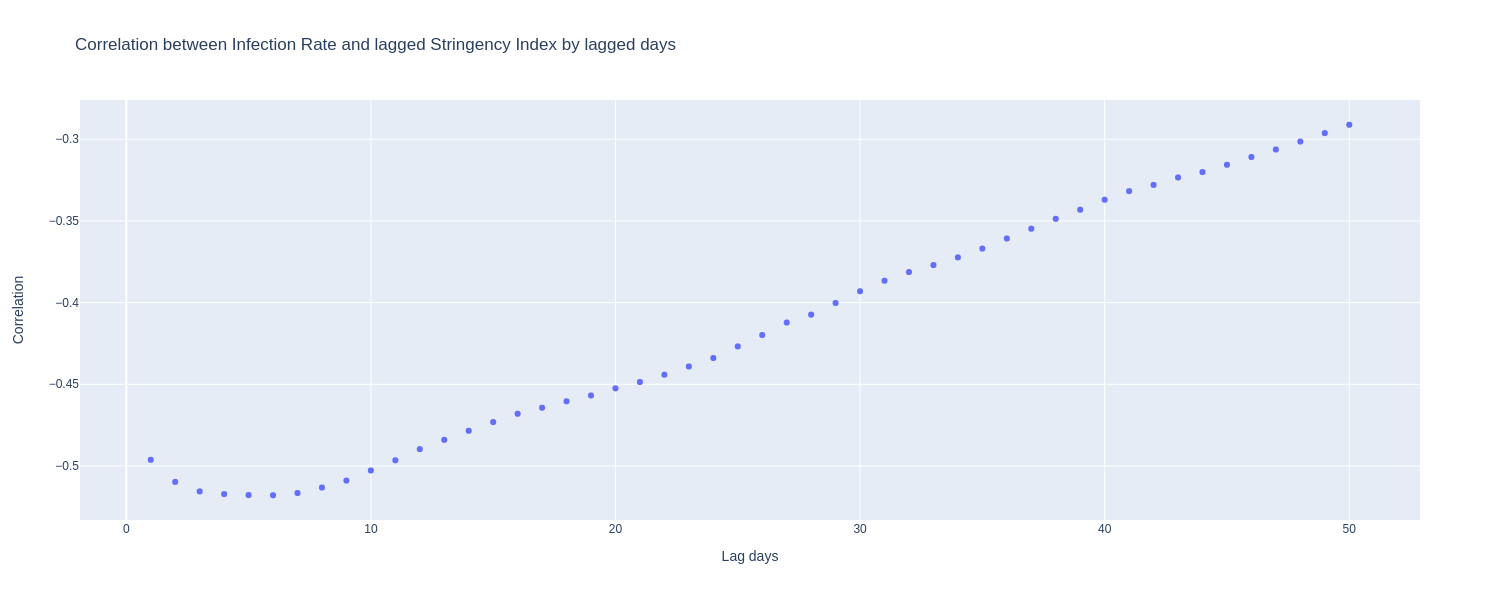

In [57]:
fig = px.scatter(x=[lag for lag in range(1, len(correlations) + 1)], y=correlations, labels={'x': 'Lag days', 'y': 'Correlation'}, title='Correlation between Infection Rate and lagged Stringency Index by lagged days', height=600, width=1500)

if github_page:
    fig.show('png', height=600, width=1500)
else:
    fig.show()

# Fitting a Linear Regression model on *infection_rate* and past values of *stringency_index*

Looking at the plots above, we can come to these conclusions:
- The *infecion_rate* feature has extremely high variance;
- The *infection_rate* seems to slightly decrease with the increase on *stringency_index* feature on past days. This relationship seems to be stronger around 6 days of lag.

A Linear Regression model will be trained on past values of *stringency_index* to predict current values of *infection_rate*.

In [58]:
from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn.linear_model import LinearRegression

# removes outliers using Local Outlier Factor
infection_rate = data['infection_rate'][data['days_into_pandemic'] >= 0]
infection_rate = infection_rate[infection_rate.notna()].values.reshape(-1, 1)
outliers = LOF(n_neighbors=500).fit_predict(infection_rate)
cleaned_infection_rate = infection_rate[outliers == 1]

# creates dataframe containing variables which the model will be trained on 
lag_days = [days for days in range(1, 15 + 1)]
to_fit = data['infection_rate']
for lag in lag_days:
    lagged_stringency_index = data['stringency_index'].groupby('location').shift(lag)
    lagged_stringency_index.name = 'stringency_index_{}_days_lagged'.format(lag)
    to_fit = pd.concat([to_fit, lagged_stringency_index], axis='columns')

# clears fit dataframe of outliers
to_fit = to_fit[to_fit['infection_rate'].isin(cleaned_infection_rate.reshape(-1))]  # selects only values that are not outliers
to_fit = to_fit.dropna()    # drops na values

# fits Linear Regression model
lr_model = LinearRegression()
lr_model = lr_model.fit(X=to_fit.loc[:, to_fit.columns != 'infection_rate'], y=to_fit['infection_rate'])

# computes R² score
score = lr_model.score(X=to_fit.loc[:, to_fit.columns != 'infection_rate'], y=to_fit['infection_rate'])

print('R_2 score is:')
print(score)


R_2 score is:
0.27293622204854207


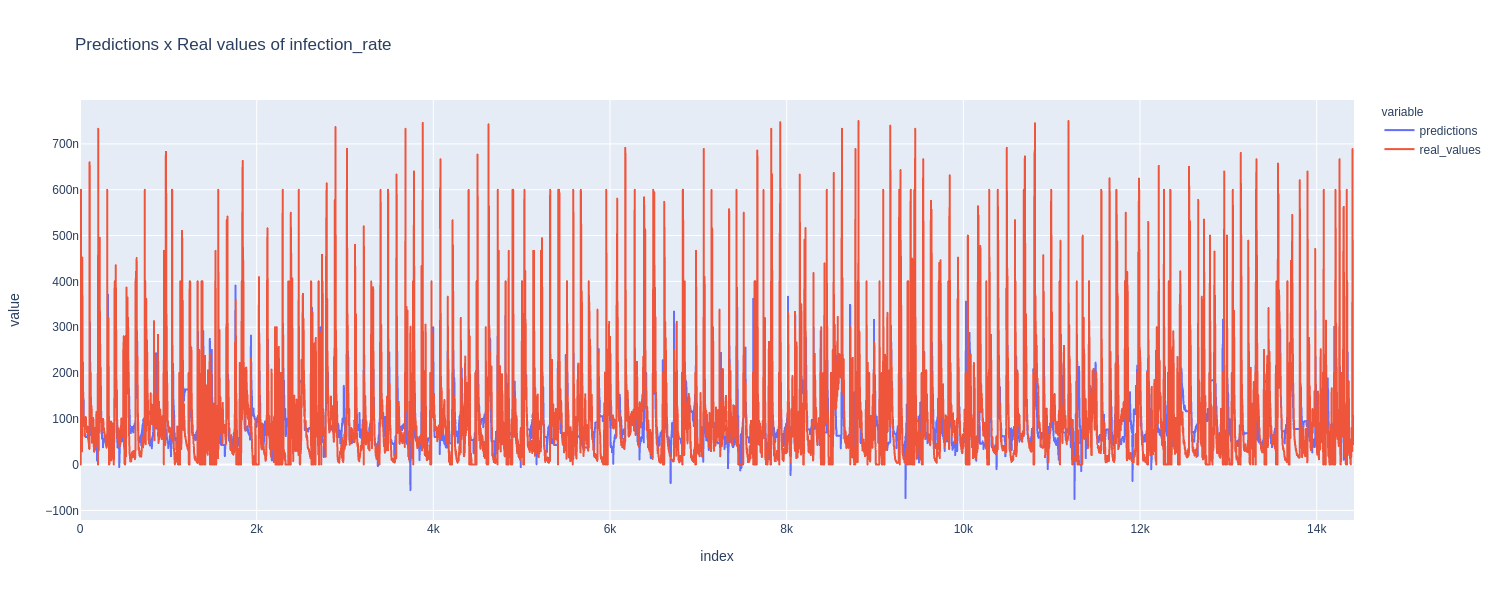

In [59]:
predictions = lr_model.predict(X=to_fit.loc[:, to_fit.columns != 'infection_rate'])
fig = px.line(data_frame={'predictions': predictions, 'real_values': to_fit['infection_rate'].values},
        labels={'x': 'teste', 'y': 'infection_rate'},
        title='Predictions x Real values of infection_rate',
        height=600, width=1500)

if github_page:
    fig.show('png', height=600, width=1500)
else:
    fig.show()

# Conclusion on linearity between *infection_rate* and past values of *stringency_index*
As can be seen above, a linear model used to predict future values of the *infection_rate* feature using the *stringency_index* doesn't do a very good job; this can be explained by the high variance of *infection_rate*, probably because it is a variable created by multiplying/dividing other variables.